Beofre carrying out any work, I import my required libraries, and load my data into a pandas DataFrame.

Import Libraries

In [2]:
import pandas as pd
import numpy as np
import prince
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Constants

In [4]:
DATA_PATH = '/Users/jenniferfortuny/02450_project/2023-09-15_jennifer_pca_section/2023-09-08_jennifer_filtered_complete_copy.csv'

Load the dataset

In [5]:
def load_data(path):
    return pd.read_csv(path)

In [6]:
def plot_histogram_boxplot(data, continuous_attributes):
    """Plot a histogram with boxplot for each continous attributes"""
    for column in continuous_attributes:
        fig = plt.figure(figsize=(10, 6))

        # Create grid
        gs = fig.add_gridspec(2, 1, height_ratios=[4, 1])
        ax1 = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1])

        # Histogram on the top axis (ax1)
        sns.histplot(data[column], kde=True, ax=ax1)
        ax1.set_title(f'Histogram with Boxplot for {column}')
        ax1.set_xlabel('')
        ax1.set_ylabel('Frequency')

        # Box plot on the bottom axis (ax2)
        sns.boxplot(x=data[column], ax=ax2)
        ax2.set_xlabel(column)

        # I find and label any outliers on the box plot with its own value
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        outliers = data[(data[column] < (Q1 - 1.5 * IQR)) | (data[column] > (Q3 + 1.5 * IQR))][column]
        for outlier in outliers:
            ax2.text(outlier, -0.18, f'{outlier: .0f}', ha='center', va='top', fontsize=8, color='blue')
        plt.tight_layout()
        plt.show()

Create data visualisation

In [7]:
def plot_histogram(data, categorical_attributes):
    """Plot a histogram for each categorical attribute."""
    for column in categorical_attributes:
        plt.figure(figsize=(10, 6))
        sns.histplot(data[column], kde=True)
        plt.title(f'Histogram for {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        # I angle the x-axis labels a bit to show all the words clearly
        plt.xticks(rotation=20, ha='right', fontsize=10)
        plt.tight_layout()
        plt.show()

Q-Q plots for continuous attributes

In [8]:
def plot_qq(data, continous_attributes):
    """Plot a Q-Q plot for a given"""
    for column in continous_attributes:
        # Since I am also using statsmodels now, in addition to matplotlib.
        # Here I create a figure and axis just for the Q-Q plot.
        plt.figure(figsize=(10, 6))
        sm.qqplot(data[column].dropna(), line='45', fit=True)
        plt.title(f'Q-Q Plot for {column}')
        plt.show()

In [9]:
def plot_correlation_heatmap(data, continous_attributes):
    """Plot a heatmap for the correlations of the continous attributes"""
    # First I calculate the correlation matrix:
    corr = data[continous_attributes].corr()
    # Then I make a heatmap:
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Heatmap')
    plt.yticks(rotation=0)
    plt.xticks(rotation=15)
    plt.show()

PCA analysis

In [10]:
def perform_pca(data_standarized):
    """Perform PCA analysis on the standarized continuous data"""
    # PCA applied without specifying the number of components.
    pca = PCA()
    principal_components_full = pca.fit_transform(data_standarized)

    # Now, I look into the explained variance.
    # I plot the explained variance ratio, to see how much variance each component explains.
    # This helps me determine a good number of PCs
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)
    
    # I check for the first n components that explain 95% or more of the variance.
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_variance, marker='o', linestyle='--', color='b')
    
    # I annotate the PCAs on the plot
    # It seems like the first 20 to 22 PCs explain over 95% of the variance in the data.
    for i in range(len(cumulative_variance)):
        plt.annotate(f"PC{i+1}: {cumulative_variance[i] * 100:.2f}%", (i, cumulative_variance[i]), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=9, color='blue')
    plt.xlabel('Number of Compnents')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Cumulative Explained Variance as Number of Components Increases')
    plt.grid(True)
    plt.show()
    return pca, principal_components_full

In [11]:
def plot_3d_scatter_for_pca(pca_coordinates):
    """Plot a 3D scatter plot of the first 3 principal components."""
    # Create a 3D scatter plot for the continuous attributes.
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Isolate the coordinates of the first 3PCs
    x = pca_coordinates[:, 0]
    y = pca_coordinates[:, 1]
    z = pca_coordinates[:, 2]

    ax.scatter(x, y, z, c="b", marker="o")

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.set_title('3D Scatter plot of the PCs for continuous data')

    plt.show()

MCA analysis

In [12]:
def perform_mca(categorical_encoded):
    """Perform PCA analysis on the encoded categorical data"""
    # I begin by initialising MCA with the prince module and fit the encoded categorical data:
    # To begin, I do not not specify the number of components.
    mca = prince.MCA()
    mca = mca.fit(categorical_encoded)
    
    # Now I transform the categorical data
    mca_coordinates = mca.transform(categorical_encoded)
    # Now, I take a look at MCA's explained inertia for each component,
    # which is similar to PCA's explained variance.
    # I start by getting the eigenvalues.
    eigenvalues = mca.eigenvalues_
    
    # Calculate the total inertia:
    total_inertia = sum(eigenvalues)

    # Now get the proportion of explained inertia:
    # Now I plot the explained inertia:
    explained_inertia = [eig/total_inertia for eig in eigenvalues]
    plt.figure(figsize=(10, 6))
    plt.plot(explained_inertia, marker='o', linestyle='--', color='b')
    # Annotating the points
    for i, inertia in enumerate(explained_inertia):
        plt.annotate(f"PC{i+1}: {inertia*100:.2f}%", (i, inertia), textcoords="offset points", xytext=(0, 10), ha='center')
    plt.xlabel('Number of Components')
    plt.ylabel('Explained Inertia')
    plt.title('Explained Inertia as Number of Components Increases')
    plt.grid(True)
    plt.show()

    # I create a 2D scatter plot for the categorical values
    # First I extract coordinates for the first two components:
    x = mca_coordinates[0]
    y = mca_coordinates[1]

    plt.figure(figsize = (10, 6))
    plt.scatter(x, y, edgecolor="k", color="blue", alpha=0.6)
    plt.title("MCA Scatter Plot for Individuals")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.grid(True)

    # Display
    plt.show()

    return mca

Load the dataset

In [13]:
data = load_data(DATA_PATH)

Splitting attributes into continuous and categorical

In [14]:
continuous_attributes = data.columns[:3]
categorical_attributes = data.columns[3:]

One-hot encoding for categorical attributes

In [15]:
categorical_encoded = pd.get_dummies(data, columns=categorical_attributes, drop_first=True)

Create data visualisations to detect outliers

1. Check for outliers <br> 
To check if the attributes are normally distributes,
I begin by reflectiong on the results of the histograms:
continous attributes:
     age: tail to the right, so right sqewed distribution.
     edu-num: looks like a bimodial distribution.
     hours-per-week: looks like an extreme plot with on highly frequent value at 35-40.
 categorical attributes:
    workclass: extreme with "Private" at the highest frequency.
    occupation: some outliers, most seem to be at the similar frequency, no clear trend.

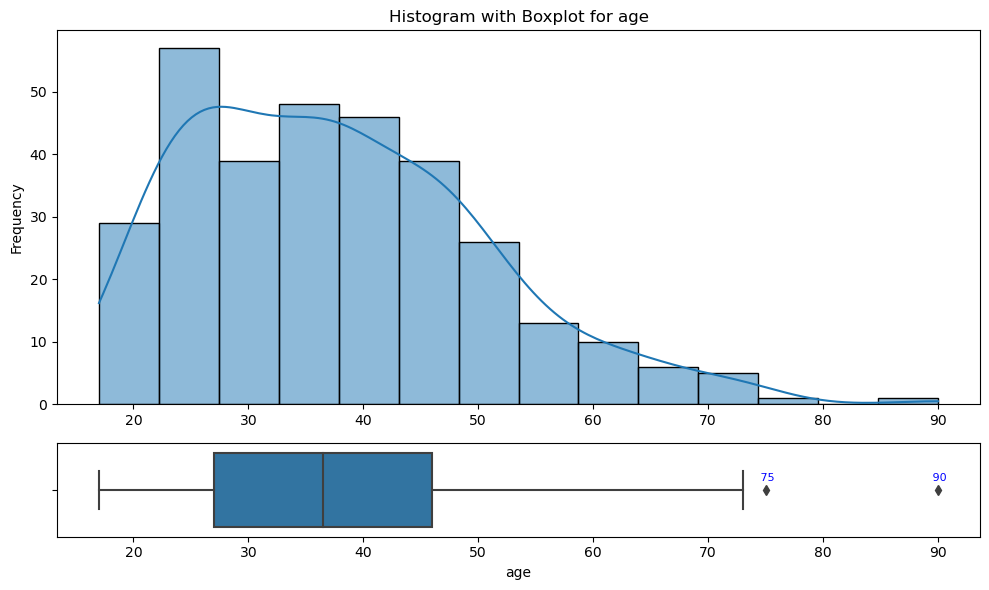

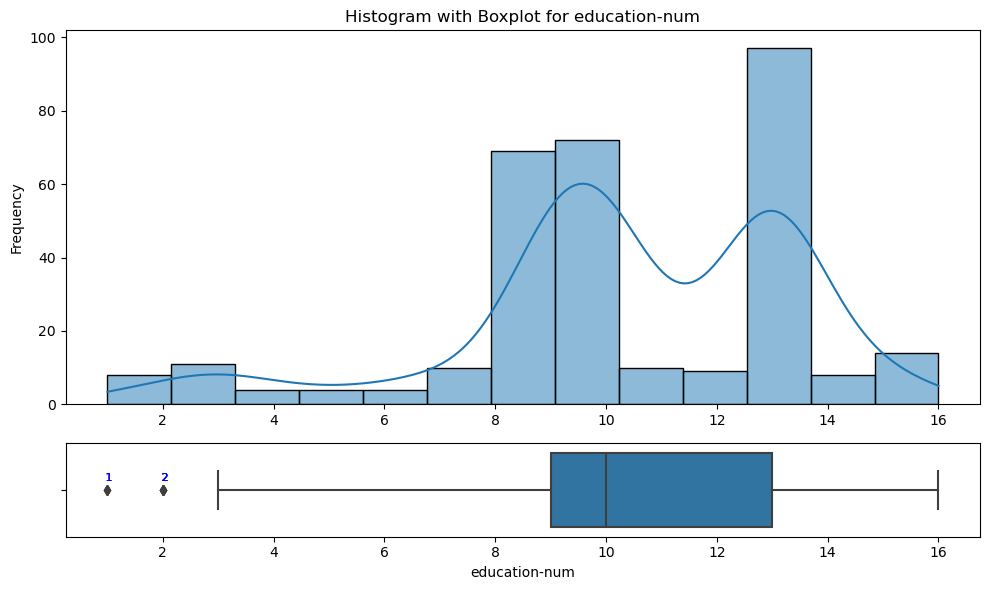

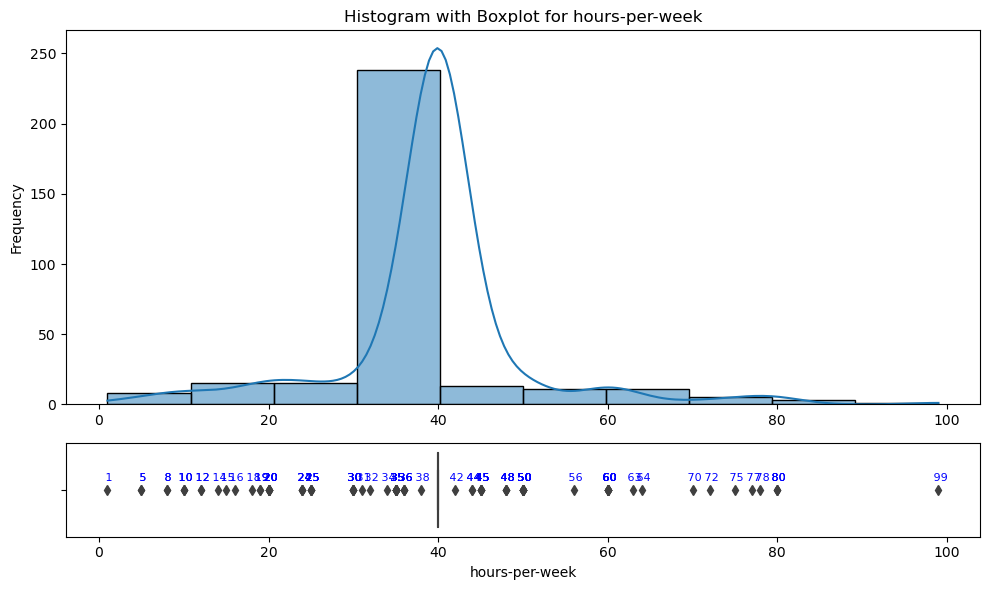

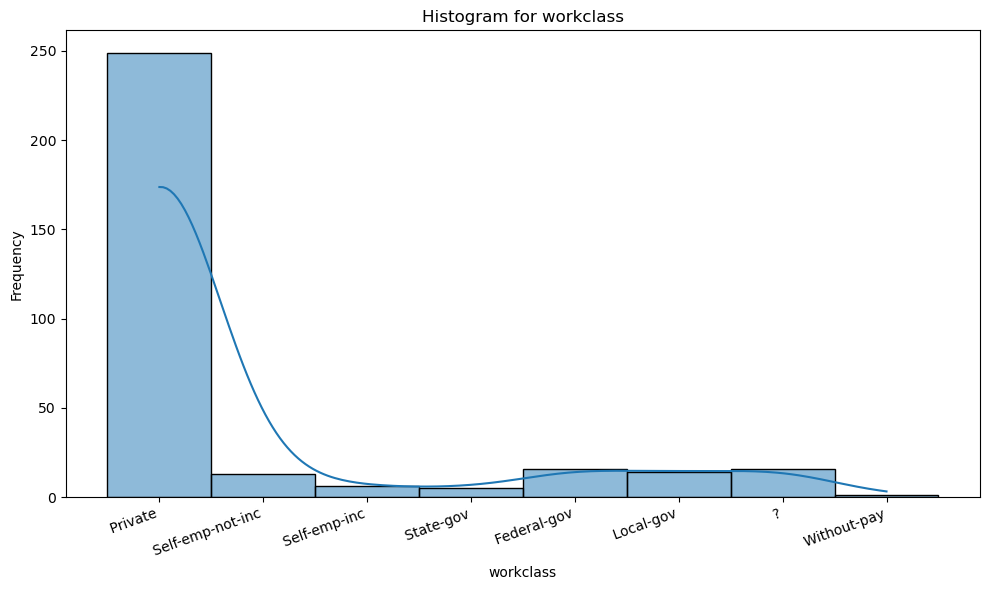

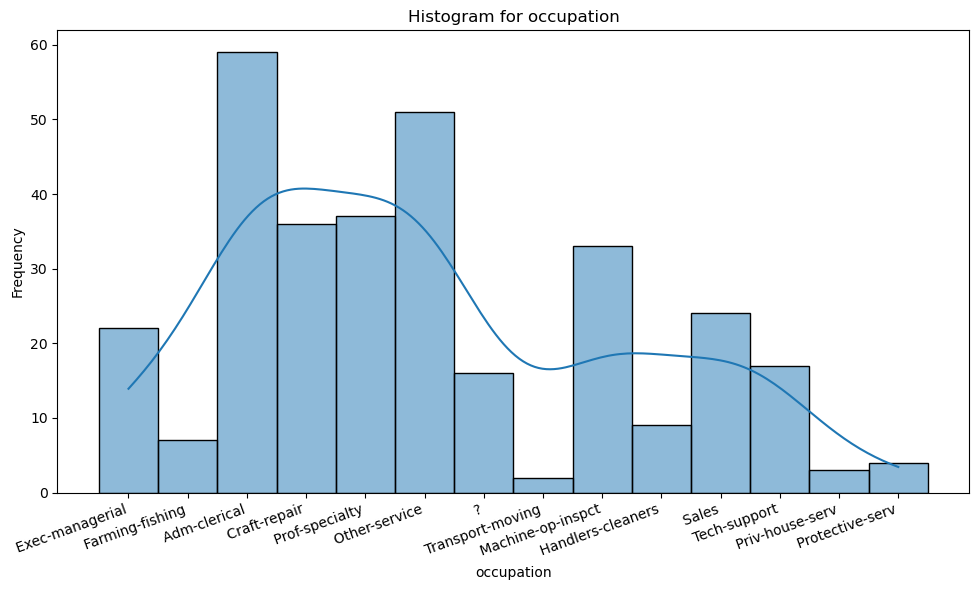

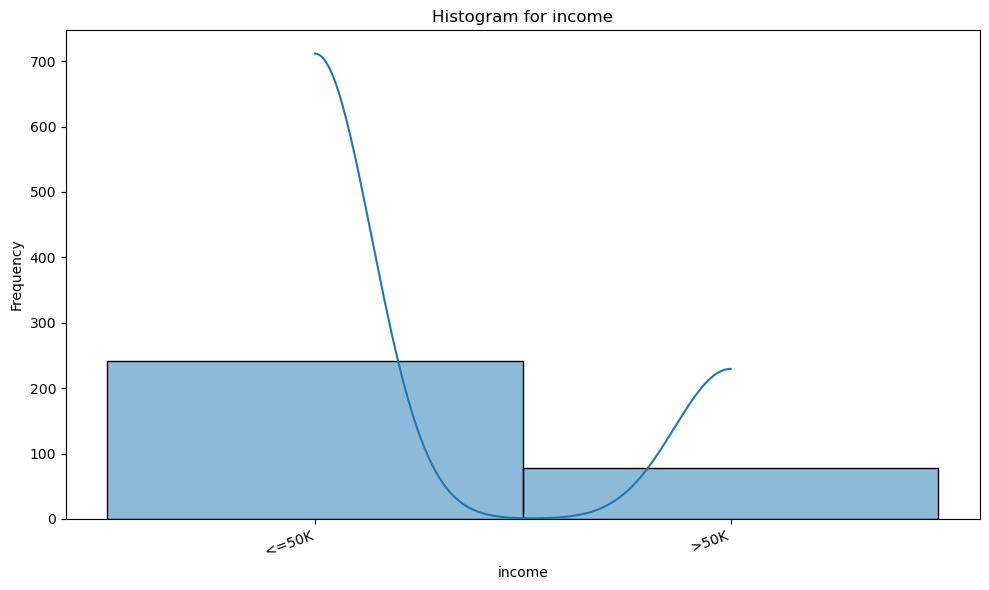

In [16]:
plot_histogram_boxplot(data, continuous_attributes)
plot_histogram(data, categorical_attributes)

Create Q-Q plots for continuous attributes to test for normal-distribution.

I use Q-Q plots to determine if they attributes have a formal normal distribution.
If the data are mostly on the y=x line in the Q-Q plot, then we can assume there is a normal distribution.
I plot the continous variables' Q-Q plots:

Notes:
The age attribute shows a U-shape pattern.
The points fall below the y=x line at the lower end, and above the line at the higher end.
This suggests we have fewere extreme values than we would expect compared to a perfect normal distribution
i.e. it is a lighter-tailed than a normal distribution.
Therefore we have a somewhat uniform distribution, what is more concentrated around the median, less so towards the tails.
This means our data could have a wide range of ages, 
and when compared to a normal distribution -  as many individuals who are very young or very old.
This could be becasue the data is focused on working age adults, which would include less people who are very young or very old.
The right skew in the histogram suggests relatively less older individuals than younger ones.

The edu-num distribution shows a shape similar to w, this suggests a binomial distribution, in agreement with the histogram.
This suggests the data has two major distributions of education levels.

The hours-per-week Q-Q plot shows a sharp incline, a long flat section, then another sharp incline.
The flat section is the major accumulation of the data, with coincides with the histogram.
The large portion of the dataset are people who work standard full-time hours.
This is a non-linear Q-Q plot, so it does NOT show a normal distribution.

For the categorical variables, I don't expect a normal distribution.
It might be more valuable to understand the frequency and mode of these attributes.
From the observations of the histogram:
The workclass attributes prodominatly represents the private sector.
The occpupation attribute shows a more uniform distribution, with some roles acting as outliers.

<Figure size 1000x600 with 0 Axes>

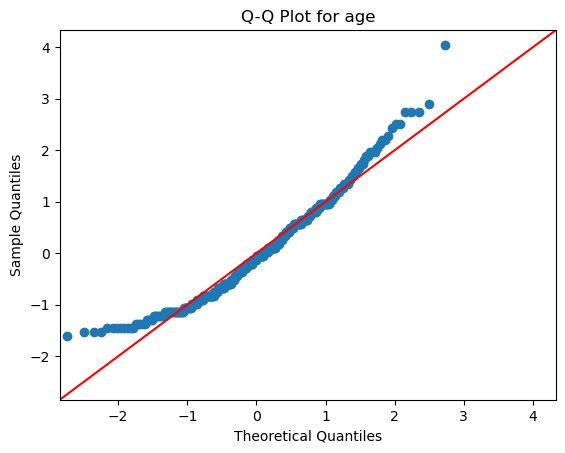

<Figure size 1000x600 with 0 Axes>

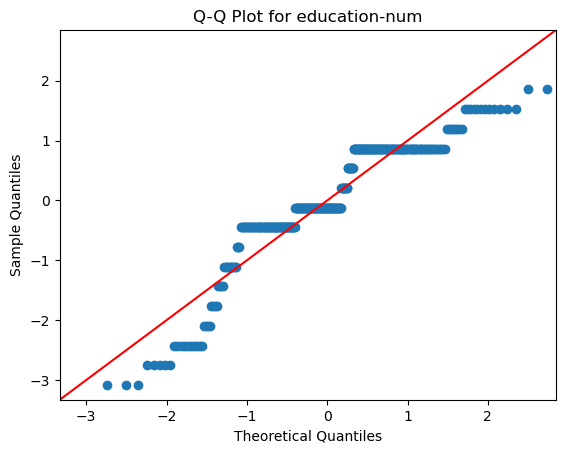

<Figure size 1000x600 with 0 Axes>

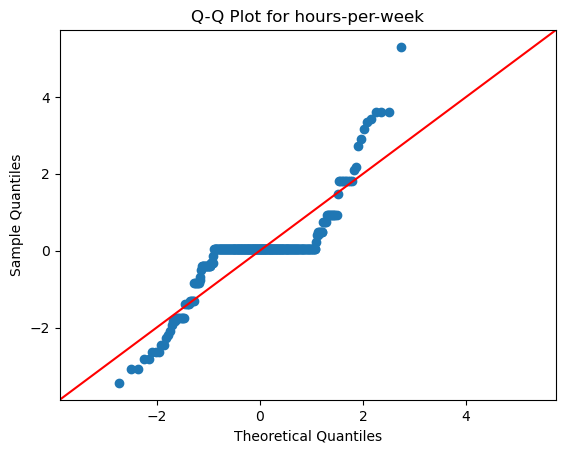

In [17]:
plot_qq(data, continuous_attributes)

Create correlation heatmap

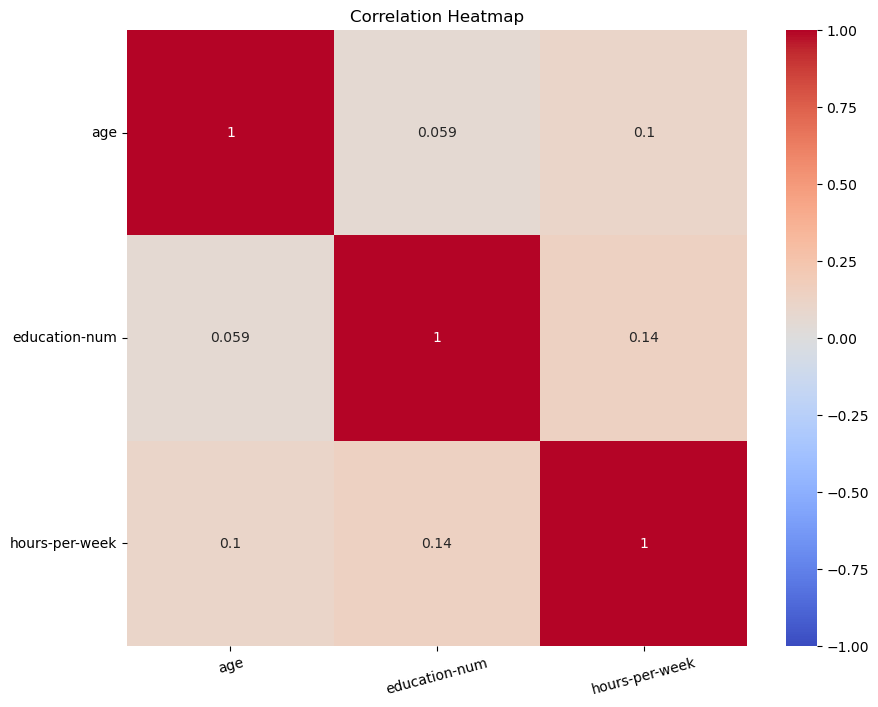

In [18]:
plot_correlation_heatmap(data, continuous_attributes)

Standarize continuous data

In [19]:
continuous_attributes_standarized = StandardScaler().fit_transform(data[continuous_attributes].dropna())

PCA analysis, with 3D scatter plot


2.Carry-out the PCA analysis:

If your attributes have different scales you,
should include the step where the data is standardizes
by the standard deviation prior to the PCA analysis.

1. The amount of variation explained as a function of the number of PCA components included.
2. The principal direction of the considered PCA components (either find a way to plot them or interpret them in terms of the features).
3. The data projected onto the considered principal components.

Now I wil carry out the PCA analysis.
I start by running the PCA without initially setting a number of components.
This helps me understand the total explained variance for each component.
It is also helpful in determining the number of PCs that would capture most of the dataset's variance.

Given that we are working with a large number of potential PCs
I carry out some dimensional reduction, 
and only use three PCs for the PCA analysis and visualisation.
I also try to retain as much information about the data as possible.
21 PCs is a lot of PCs. This is most likely the result of having used one-hot encoding for our categorical data.

Given this situation. I would like to apply the PCA only to the continous part,
and the MCA on the categorical part.

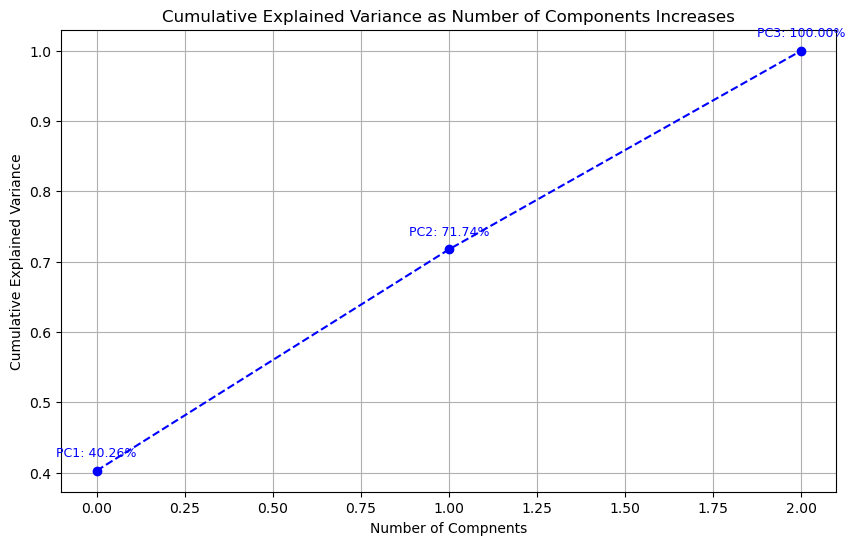

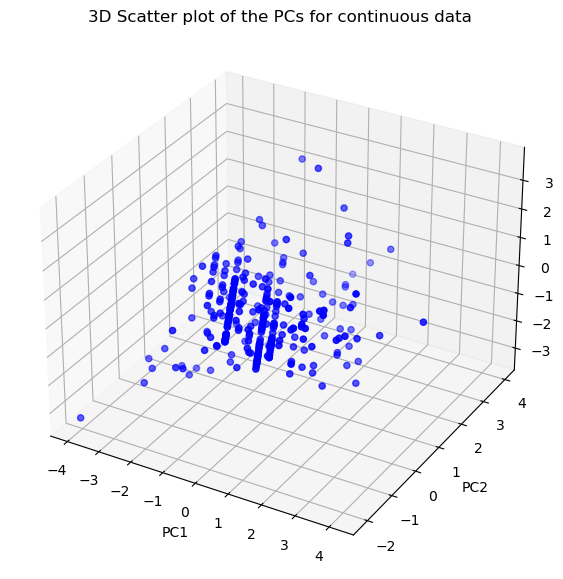

In [20]:
pca, pca_coordinates = perform_pca(continuous_attributes_standarized)
plot_3d_scatter_for_pca(pca_coordinates)

MCA analysis

Noting the result from this MCA analysis on the categorical data,
where 2 PCs explain all the variation.

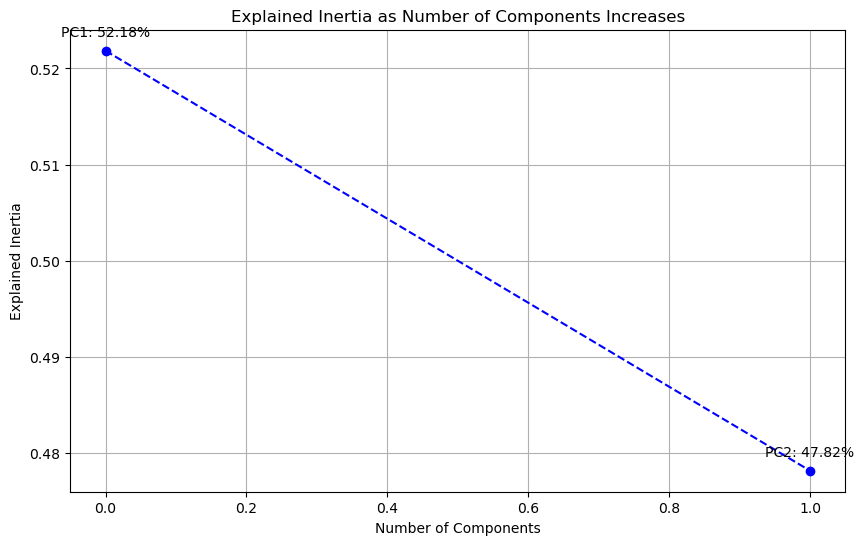

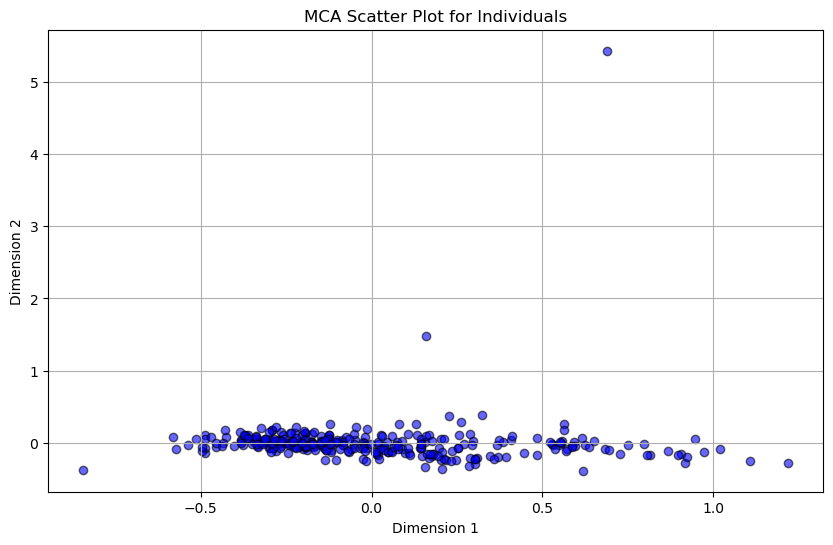

MCA()

In [21]:
perform_mca(categorical_encoded)